In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

# Experience Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Enhanced UAV Environment with AoI
class AoIEnhancedSmallUAVEnv:
    def __init__(self):
        self.position = [0, 0]
        self.goal = [3, 3]
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        self.grid_size = 4
        self.age_of_information = 0

    def reset(self):
        self.position = [0, 0]
        self.age_of_information = 0
        return self.get_state()

    def get_state(self):
        dx = self.goal[0] - self.position[0]
        dy = self.goal[1] - self.position[1]
        return [self.position[0], self.position[1], dx, dy, self.age_of_information]

    def step(self, action):
        new_position = [self.position[0] + self.actions[action][0], self.position[1] + self.actions[action][1]]

        self.age_of_information += 1

        if new_position[0] < 0 or new_position[0] >= self.grid_size or new_position[1] < 0 or new_position[1] >= self.grid_size:
            return self.get_state(), -1, False

        self.position = new_position

        if self.position == self.goal:
            self.age_of_information = 0
            return self.get_state(), 10, True

        reward = -1.0 / self.age_of_information
        return self.get_state(), reward, False

# Actor-Critic Model
class ActorCritic(nn.Module):
    def __init__(self, input_dim, num_actions):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )
        self.critic = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        return self.actor(x), self.critic(x)

# Training function
def train_ac_with_replay(env, model, memory, episodes=1000, gamma=0.99, lr=0.001, max_steps=100, batch_size=64):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    episode_rewards = []
    aoi_per_episode = []  # Store AoI for each episode

    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        aoi_for_this_episode = []

        while not done:
            aoi_for_this_episode.append(state[-1])  # Append the AoI value

            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_probs, value = model(state_tensor)
            action_dist = torch.distributions.Categorical(logits=action_probs)
            action = action_dist.sample().item()
            
            next_state, reward, done = env.step(action)
            total_reward += reward

            memory.push((state, action, reward, next_state, done))
            
            if len(memory) > batch_size:
                transitions = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)

                batch_state = torch.tensor(batch_state, dtype=torch.float32)
                batch_action = torch.tensor(batch_action, dtype=torch.long)
                batch_reward = torch.tensor(batch_reward, dtype=torch.float32)
                batch_next_state = torch.tensor(batch_next_state, dtype=torch.float32)
                batch_done = torch.tensor(batch_done, dtype=torch.bool)

                _, next_value = model(batch_next_state)
                target_value = batch_reward + gamma * next_value.squeeze(1) * (~batch_done)
                current_action_probs, current_value = model(batch_state)
                current_dist = torch.distributions.Categorical(logits=current_action_probs)
                log_prob = current_dist.log_prob(batch_action)
                
                advantage = target_value - current_value.squeeze(1)
                actor_loss = -(log_prob * advantage.detach()).mean()
                critic_loss = 0.5 * advantage.pow(2).mean()
                loss = actor_loss + critic_loss
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            state = next_state

        episode_rewards.append(total_reward)
        aoi_per_episode.append(sum(aoi_for_this_episode) / len(aoi_for_this_episode))  # Calculate average AoI for this episode

        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")

    return episode_rewards, aoi_per_episode

# Main Execution
memory = ReplayMemory(capacity=1000)
env = AoIEnhancedSmallUAVEnv()
model = ActorCritic(input_dim=5, num_actions=4)
rewards, average_aoi = train_ac_with_replay(env, model, memory, episodes=10, lr=0.001, max_steps=1)

# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Rewards over Episodes")

plt.subplot(1, 2, 2)
plt.plot(average_aoi)
plt.xlabel("Episode")
plt.ylabel("Average Age of Information (AoI)")
plt.title("Average AoI over Episodes")

plt.tight_layout()
plt.show()


Episode 1/10, Total Reward: 5.72711414402591
Episode 2/10, Total Reward: 7.4071428571428575
Episode 3/10, Total Reward: -21.21648480718248


KeyboardInterrupt: 

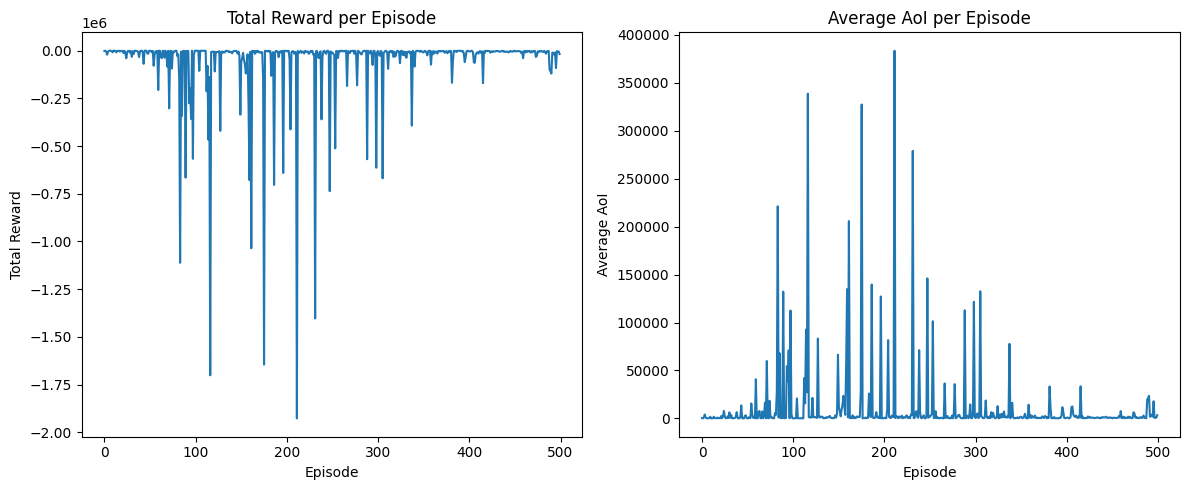

In [4]:
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt

# Enhanced UAV Environment with Age of Information (AoI)
class AoIUAVEnv:
    def __init__(self):
        self.position = [0, 0]
        self.goal = [3, 3]
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Up, Right, Down, Left
        self.grid_size = 4  # Size of the grid
        self.aoi = 0

    def reset(self):
        self.position = [0, 0]
        self.aoi = 0
        return self.get_state()

    def get_state(self):
        # Distance and direction to the goal from current position
        dx = self.goal[0] - self.position[0]
        dy = self.goal[1] - self.position[1]
        return [self.position[0], self.position[1], dx, dy, self.aoi]

    def step(self, action):
        # Update position
        new_position = [self.position[0] + self.actions[action][0], self.position[1] + self.actions[action][1]]
        self.aoi += 1  # Increase the Age of Information

        # Check if out of grid
        if new_position[0] < 0 or new_position[0] >= self.grid_size or new_position[1] < 0 or new_position[1] >= self.grid_size:
            return self.get_state(), -5 - self.aoi, False

        # Update to new position
        self.position = new_position

        # Check if goal is reached
        if self.position == self.goal:
            reward = 10 - self.aoi
            self.aoi = 0  # Reset the Age of Information
            return self.get_state(), reward, True

        return self.get_state(), -1 - self.aoi, False

# DQN Model
class AoIDQN(nn.Module):
    def __init__(self, input_dim, num_actions):
        super(AoIDQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, num_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Training function
def train_dqn(env, model, episodes=100, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    num_actions = 4
    epsilon = epsilon_start
    episode_rewards = []
    episode_aois = []

    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        total_aoi = 0

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            if random.uniform(0, 1) < epsilon:
                action = random.choice(range(num_actions))
            else:
                q_values = model(state_tensor)
                action = torch.argmax(q_values).item()

            next_state, reward, done = env.step(action)
            total_reward += reward
            total_aoi += state[-1]  # AoI is the last element of the state

            next_q_values = model(torch.tensor(next_state, dtype=torch.float32))
            target = reward + gamma * torch.max(next_q_values)
            
            q_value = model(state_tensor)[action]
            loss = criterion(q_value, target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state

        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        episode_rewards.append(total_reward)
        episode_aois.append(total_aoi/len(state))

    return episode_rewards, episode_aois

# Execution and Visualization
env = AoIUAVEnv()
model = AoIDQN(input_dim=5, num_actions=4)
rewards, aois = train_dqn(env, model, episodes=500)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rewards)
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(1, 2, 2)
plt.plot(aois)
plt.title('Average AoI per Episode')
plt.xlabel('Episode')
plt.ylabel('Average AoI')
plt.tight_layout()
plt.show()
